In [1]:
import json
import shap
import graphviz
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from IPython.display import Image
from scipy.stats import spearmanr, pearsonr
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error
from consts import DATA_CLEAN_ACTION_PATH_X, DATA_CLEAN_ACTION_PATH_Y, DATA_GAME_REVIEWS_PATH, reaction_time_bins, PROBA2GO_DICT, REVIEWS_DICT

/anaconda/envs/final_project_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Loading the data

In [2]:
X_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_X)
y_df = pd.read_csv(DATA_CLEAN_ACTION_PATH_Y)
X_df['user_id'] = X_df['user_id'].apply(lambda x: 'X_' + str(x))
y_df['user_id'] = y_df['user_id'].apply(lambda x: 'y_' + str(x))
labels = range(len(reaction_time_bins) + 1)
bin_edges = [-1] + [b[0] for b in reaction_time_bins] + [reaction_time_bins[-1][1]]
bin_labels = ["-1-0"] + [f"{b[0]}-{b[1]}" if b[1] != np.inf else f"{b[0]}+" for b in reaction_time_bins]

### Adding Reviews Features

In [3]:
hotel_dfs = dict()
with open("data/baseline_proba2go.txt", 'r') as file:
    probs_dict = json.load(file)

def add_review_prob(row):
    review_id = row['reviewId']
    return probs_dict[str(review_id)]

def get_review_scores(row):
    review_id = row['reviewId']
    review_scores_dict = REVIEWS_DICT[review_id]
    return review_scores_dict

### Adding Mistakes Features

In [4]:
def add_mistakes_columns(df):
    # Calculate the cumulative sum of mistakes, then shift within each group so the calculation will be correct to the start of the round
    df['mistakes_cumulative'] = df.groupby(['user_id', 'gameId'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['current_game_mistakes_amount'] = df.groupby(['user_id', 'gameId'])['mistakes_cumulative'].shift(fill_value=0)  
    
    # Calculate cumulative mistakes across all games for each user, then shift  
    df['total_mistakes_cumulative'] = df.groupby(['user_id'])['didWin'].transform(lambda x: (~x).cumsum())  
    df['total_games_mistakes_amount'] = df.groupby(['user_id'])['total_mistakes_cumulative'].shift(fill_value=0)  
    
    # For percentage calculations, adjust for the shift by avoiding division by zero  
    df['rounds_so_far'] = df.groupby(['user_id', 'gameId']).cumcount()  
    df['total_rounds_so_far'] = df.groupby(['user_id']).cumcount() 
    df['current_game_mistakes_percentage'] = df['current_game_mistakes_amount'] / df['rounds_so_far'].replace(0, pd.NA)  
    df['total_games_mistakes_percentage'] = df['total_games_mistakes_amount'] / df['total_rounds_so_far'].replace(0, pd.NA)  
    
    # Fill NaN values in the percentage columns  
    df.fillna({'current_game_mistakes_percentage': 0, 'total_games_mistakes_percentage': 0}, inplace=True)  
    df.drop(['mistakes_cumulative', 'total_mistakes_cumulative', 'rounds_so_far', 'total_rounds_so_far'], axis=1, inplace=True)
    return df

### Extracting Players Strategies

In [5]:
from Simulation.dm_strategies import BOT_ACTION, REVIEWS
def history_and_review_quality(history_window, quality_threshold, information):      
    if len(information["previous_rounds"]) == 0 \
            or history_window == 0 \
            or np.min(np.array([((r[BOT_ACTION] >= 8 and r[REVIEWS] >= 8)
                                    or (r[BOT_ACTION] <= 8 and r[REVIEWS] < 8)) for r in
                                information["previous_rounds"][
                                -history_window:]])) == 1:          
        if information["bot_message"] >= quality_threshold: 
            return 1
        else:
            return 0
    else:
        return 0
    
def LLM_based(information):
    proba2go = {int(k): v for k, v in PROBA2GO_DICT.items()}
    review_llm_score = proba2go[information["review_id"]]
    return int(np.random.rand() <= review_llm_score)


def create_information(group):
    group['information'] = [
        [(hotel_score, review_score) for hotel_score, review_score in zip(group['hotelScore'][:i], group['review_score'][:i])] 
        for i in range(len(group))
    ]
    return group

def calculate_played_oracle(group):
    did_win = group['didWin'].values
    played_oracle = [0] * len(did_win)
    for i in range(1, len(did_win) - 1):
        if all(did_win[i: len(group)]):
            played_oracle[i:] = [1] * (len(group) - i)
            break
    group['played_oracle'] = played_oracle
    return group


def calculate_trustful_and_llm(row, user_properties):
    user_id = row['user_id']
    review_id = row['reviewId']
    bot_message = row['review_score']
    history_window = user_properties[user_id]['history_window']
    quality_threshold = user_properties[user_id]['quality_threshold']
    information = {'previous_rounds': row['information'], 'bot_message': bot_message, 'review_id': review_id}
    
    trustful_decision = history_and_review_quality(history_window, quality_threshold, information)
    llm_decision = LLM_based(information)
    
    return pd.Series([trustful_decision, llm_decision])


def lost_cause(row, strategy_threshold_dict):
    if 10 - strategy_threshold_dict[row['strategy_id']] < row['current_game_mistakes_amount']:
        return 1 
    else:
        return 0

### Adding All features

In [6]:
def pre_process(actions_df, bot_thresholds):
    actions_df['reaction_time_bins'] = pd.cut(actions_df['reaction_time'], bins=bin_edges, include_lowest=True)
    actions_df['last_reaction_time_bins'] = pd.cut(actions_df['last_reaction_time'], bins=bin_edges, include_lowest=True)
    actions_df['last_reaction_time_bins_categories'] = actions_df['last_reaction_time_bins'].apply(lambda x: (x.left))
    actions_df['reaction_time_bins_categories'] = actions_df['reaction_time_bins'].apply(lambda x: (x.left))
    scores_series = actions_df.apply(get_review_scores, axis=1)
    scores_df = pd.DataFrame(scores_series.tolist())
    actions_df = pd.concat([actions_df, scores_df], axis=1)
    actions_df = add_mistakes_columns(actions_df)
    actions_df['user_earned_more'] = actions_df['user_points'] >= actions_df['bot_points']
    actions_df['bot_earned_more'] = actions_df['user_points'] < actions_df['bot_points']
    actions_df['review_prob'] = actions_df.apply(add_review_prob, axis=1)

    user_properties = {
    user_id: {
        'history_window': np.random.negative_binomial(2, 1 / 2) + np.random.randint(0, 2),
        'quality_threshold': np.random.normal(8, 0.5),
        'random_noise': np.random.normal(0, 0.1)
    } 
    for user_id in actions_df['user_id'].unique()
    }

    strategies_df = actions_df[['user_id', 'gameId', 'reviewId', 'strategy_id', 'hotelScore', 'review_score', 'didWin', 'didGo']] \
        .groupby(by=['user_id', 'gameId']).apply(create_information).reset_index(drop=True)
    strategies_df = strategies_df.groupby(by=['user_id', 'gameId']).apply(calculate_played_oracle).reset_index(drop=True)
    strategies_df[['trustful_decision', 'llm_decision']] = strategies_df.apply(lambda row: calculate_trustful_and_llm(row, user_properties), axis=1)
    strategies_df['played_trustful'] = (strategies_df['trustful_decision'] == strategies_df['didGo']).astype(int)
    strategies_df['played_llm'] = (strategies_df['llm_decision'] == strategies_df['didGo']).astype(int)
    actions_df = actions_df.merge(strategies_df)
    actions_df['played_random'] = actions_df.apply(lost_cause, args=(bot_thresholds,), axis=1)
    actions_df.loc[actions_df[actions_df['played_oracle'] == 1].index, ['played_trustful', 'played_llm', 'played_random']] = 0
    return actions_df

- random: lost_cause = True 
- oracle: the player only wins from now, at least 3 winnings (excluding the first round). if oracle is true then no other strategy is true 
- LLM: same as in the simulation
- Trustful: once the bot lied, the player won't play trustful anymore

- if trustful then go by llm, else go oposite than llm

In [7]:
bot_thresholds_X = {3: 10, 0: 7, 2: 9, 5: 9, 59: 8, 19: 9}
bot_thresholds_Y = {132: 10, 23: 9, 107: 9, 43: 9, 17: 9, 93: 9}

train_df = pre_process(X_df, bot_thresholds_X)
test_df = pre_process(y_df, bot_thresholds_Y)

### EDA

In [19]:
all_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob', 'review_score',
                'review_length', 'positive_review_proportion','negative_review_proportion','positive_negative_proportion','negative_positive_proportion', 'negative_score',
                'positive_score', 'neutral_score', 'compound_score',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount',
                'user_earned_more', 'bot_earned_more', 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle']

regression_label_column = 'reaction_time'
classification_label_column = 'reaction_time_bins_categories'

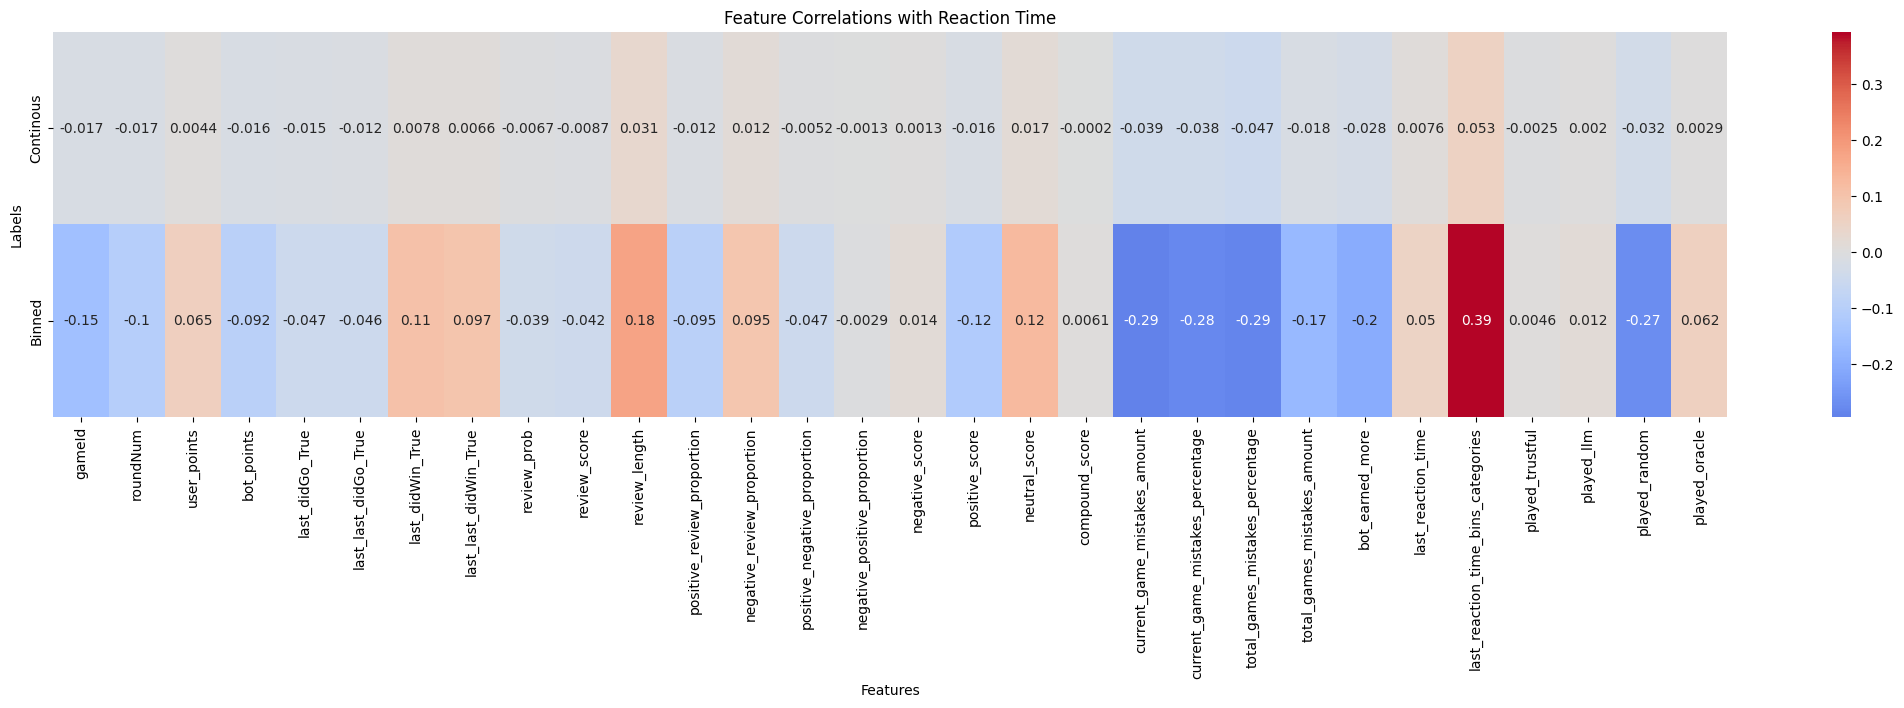

In [24]:
clean_features = ['gameId', 'roundNum', 'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True', 'last_didWin_True', 'last_last_didWin_True', 'review_prob', 'review_score',
                'review_length', 'positive_review_proportion','negative_review_proportion','positive_negative_proportion','negative_positive_proportion', 'negative_score',
                'positive_score', 'neutral_score', 'compound_score',
                'current_game_mistakes_amount', 'current_game_mistakes_percentage', 'total_games_mistakes_percentage', 'total_games_mistakes_amount',
                'bot_earned_more', 'last_reaction_time', 'last_reaction_time_bins_categories', 'played_trustful', 'played_llm', 'played_random', 'played_oracle']

regression_correlations = train_df[clean_features].apply(lambda x: x.corr(train_df[regression_label_column]))
classification_correlations = train_df[clean_features].apply(lambda x: x.corr(train_df[classification_label_column]))
correlations_df = pd.DataFrame({
    'Continous': regression_correlations,
    'Binned': classification_correlations
}).T

plt.figure(figsize=(27, 5))
sns.heatmap(correlations_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations with Reaction Time')
plt.xlabel('Features')
plt.ylabel('Labels')
plt.show()

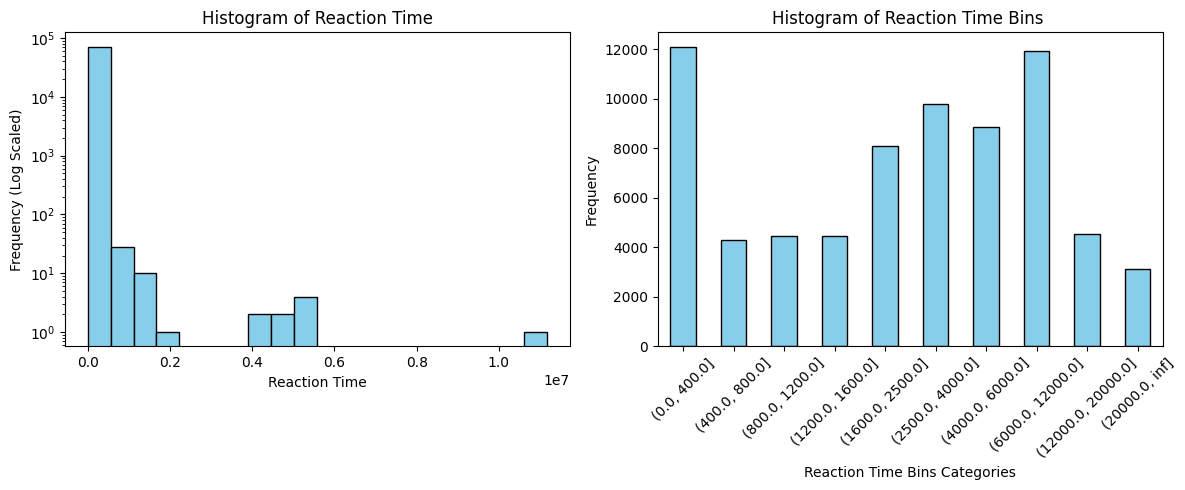

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for the regression label (reaction_time)
axes[0].hist(train_df['reaction_time'], bins=20, color='skyblue', edgecolor='black', log=True)
axes[0].set_title('Histogram of Reaction Time')
axes[0].set_xlabel('Reaction Time')
axes[0].set_ylabel('Frequency (Log Scaled)')

# Plot histogram for the classification label (reaction_time_bins_categories)
bins_count = train_df['reaction_time_bins'].value_counts()
bins_count = bins_count[bins_count > 0]
bins_count.sort_index().plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Histogram of Reaction Time Bins ')
axes[1].set_xlabel('Reaction Time Bins Categories')
axes[1].set_ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

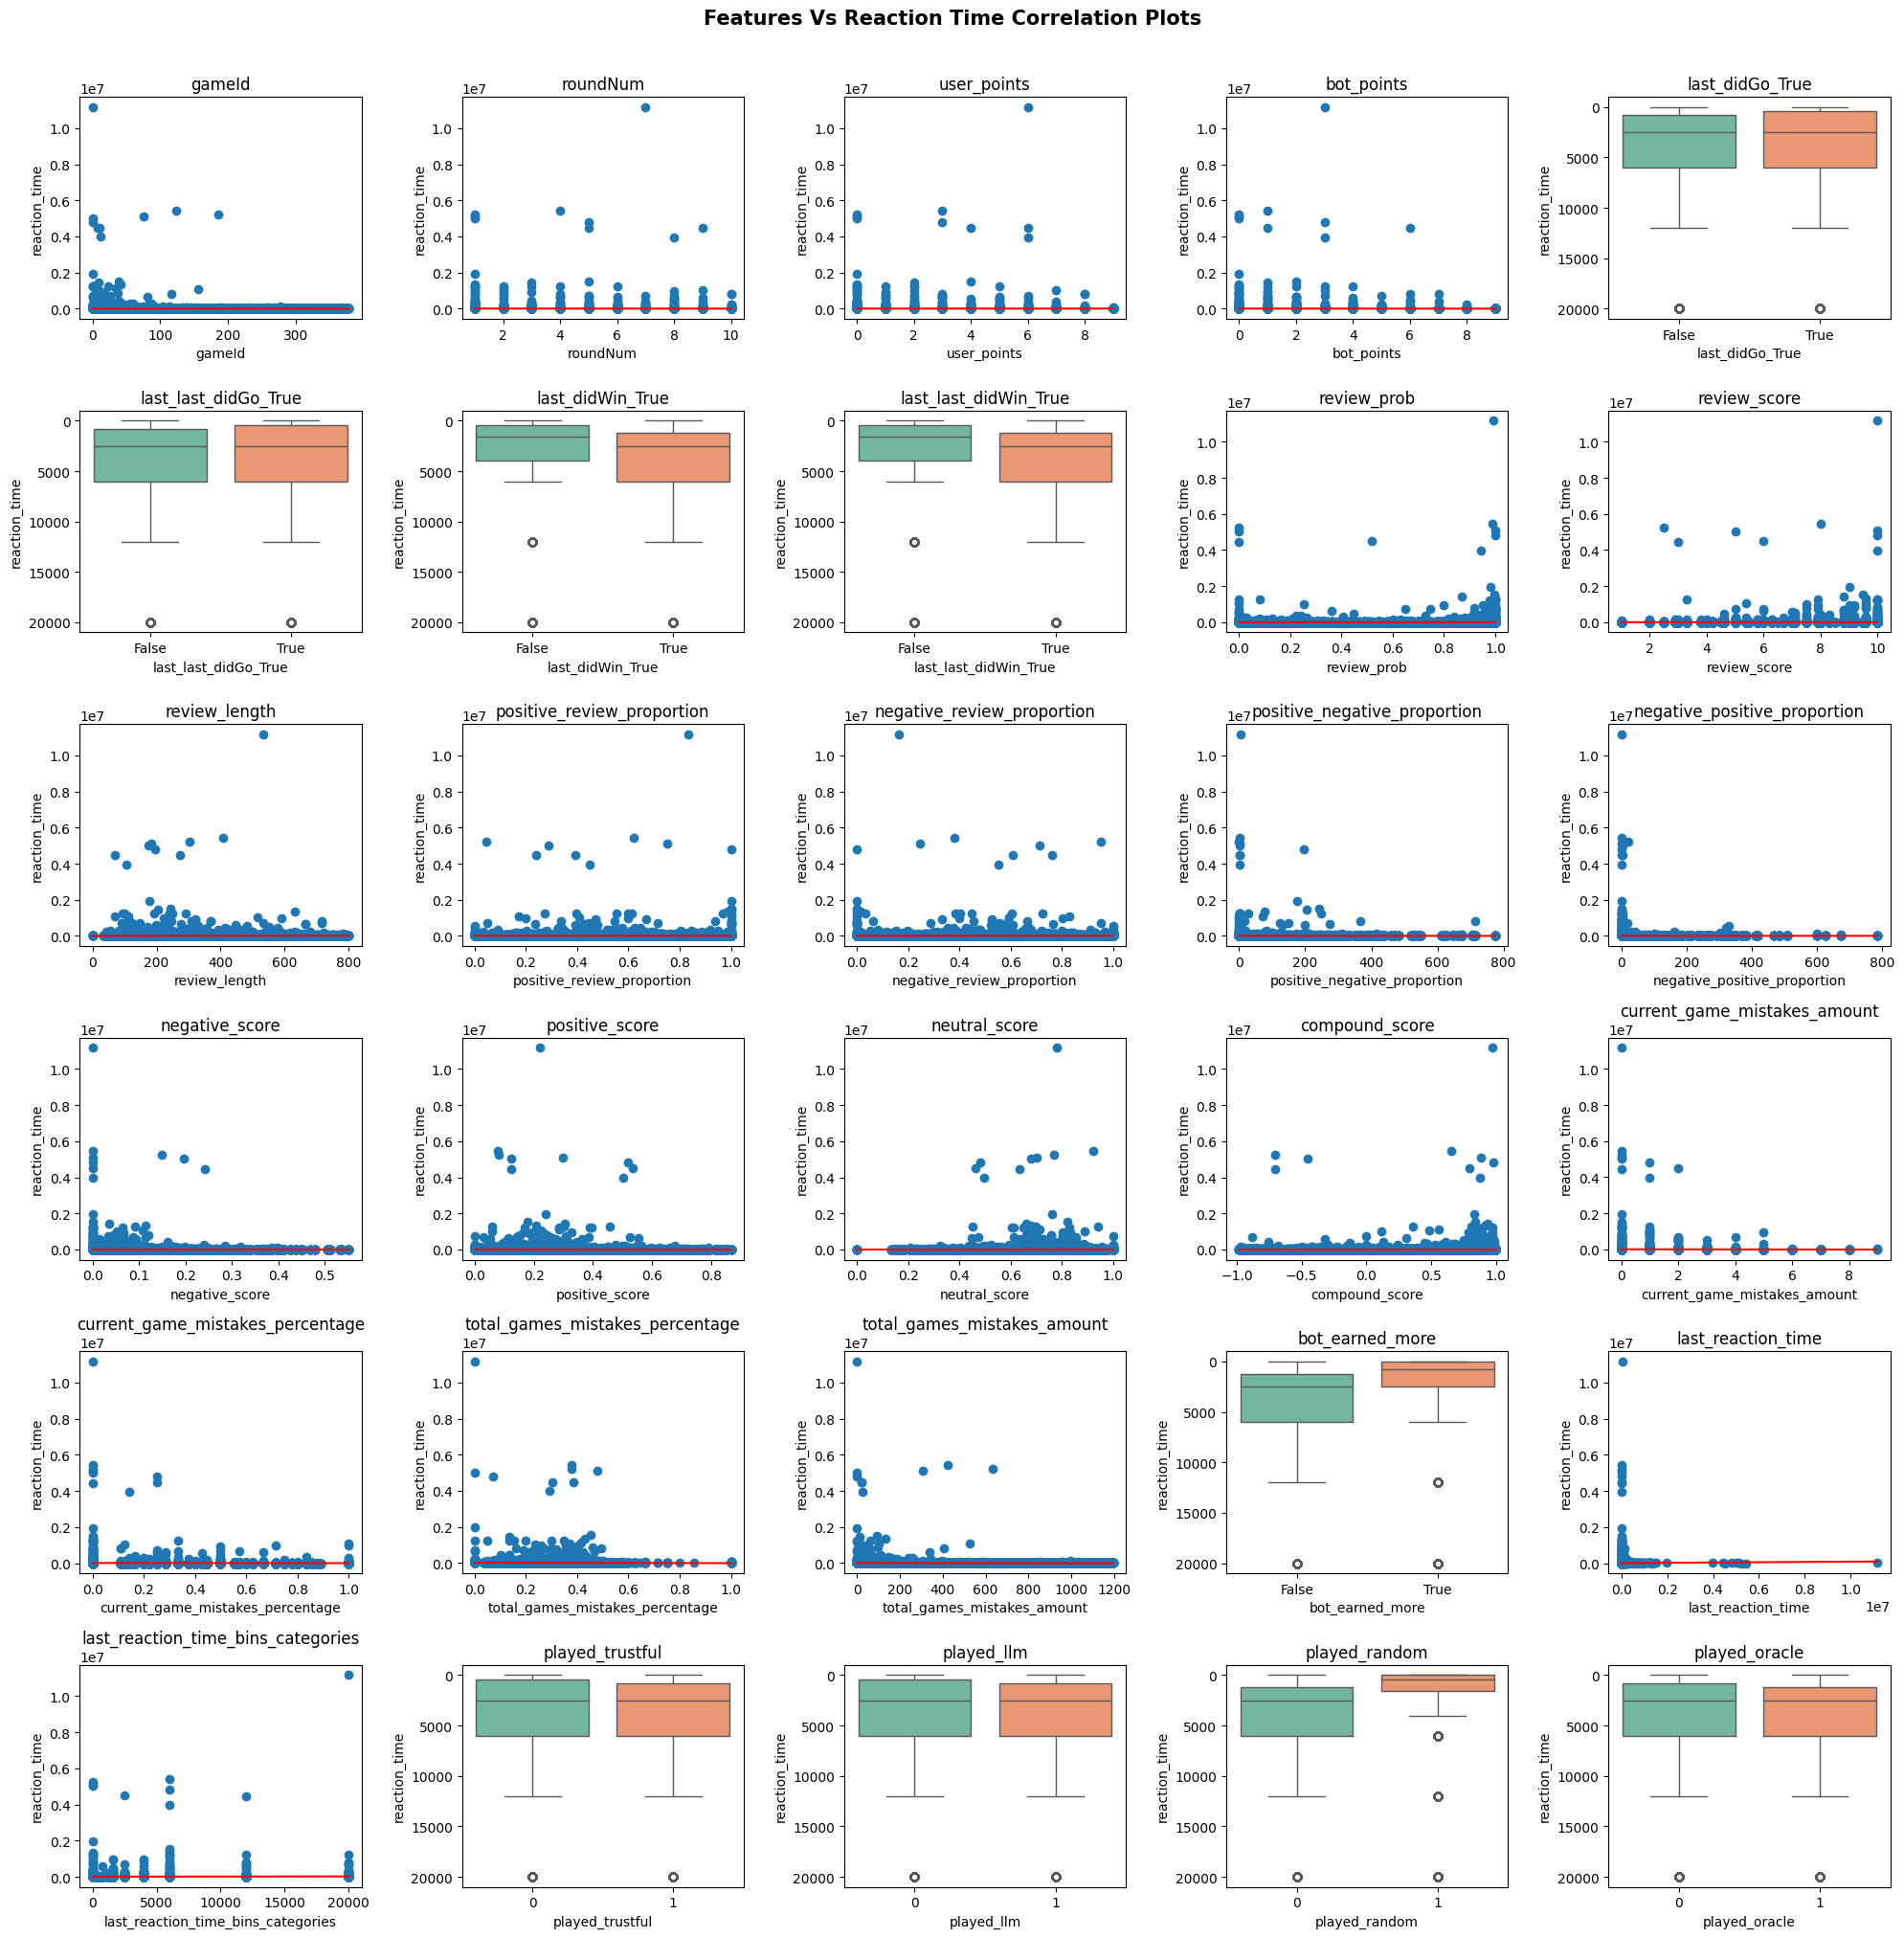

In [30]:
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(6, 5, figsize=(20, 20))
axes = axes.flatten()

# Plot correlation plots
for i, feature in enumerate(clean_features):
    if train_df[feature].nunique() > 9:
        coefficients = np.polyfit(train_df[feature], train_df[regression_label_column], 1)
        polynomial = np.poly1d(coefficients)
        x_values = np.linspace(min(train_df[feature]), max(train_df[feature]), 100)
        y_values = polynomial(x_values)
        axes[i].plot(x_values, y_values, color='red', label='Regression Line')
        axes[i].scatter(train_df[feature], train_df[regression_label_column], label='Data Points')
        
    else:
        sns.boxplot(x=train_df[feature].astype(str), y=train_df[classification_label_column], ax=axes[i], palette="Set2")
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(regression_label_column)

#axes[-1].remove()
plt.suptitle('Features Vs Reaction Time Correlation Plots', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

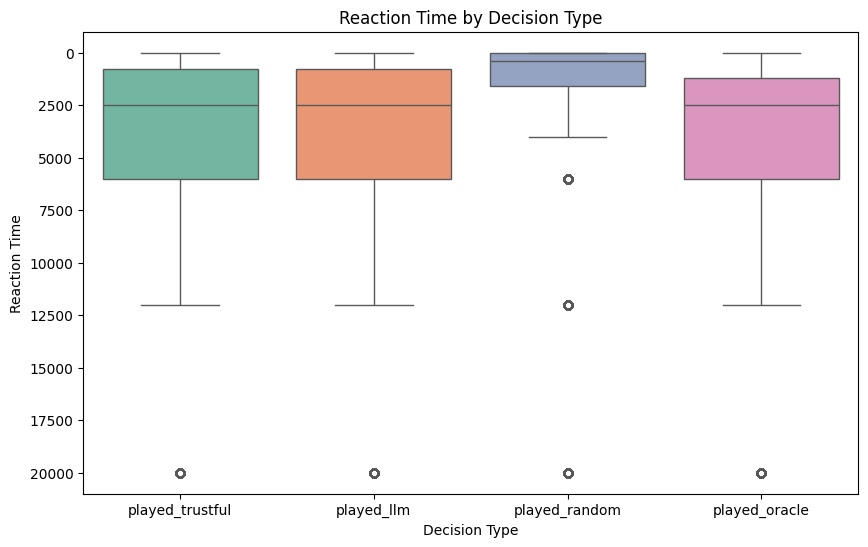

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


copy_train_df = train_df.copy()
copy_train_df['played_trustful'] = copy_train_df['trustful_decision'].astype(bool)
copy_train_df['played_llm'] = copy_train_df['llm_decision'].astype(bool)
copy_train_df['played_random'] = copy_train_df['played_random'].astype(bool)
copy_train_df['played_oracle'] = copy_train_df['played_oracle'].astype(bool)

# Create a melted DataFrame for easier plotting
melted_df = copy_train_df.melt(
    id_vars=['reaction_time_bins_categories'],
    value_vars=['played_trustful', 'played_llm', 'played_random', 'played_oracle'],
    var_name='decision_type',
    value_name='played'
)

# Filter only true values
melted_df = melted_df[melted_df['played']]

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(x='decision_type', y=classification_label_column, data=melted_df, palette='Set2')
plt.title('Reaction Time by Decision Type')
plt.xlabel('Decision Type')
plt.ylabel('Reaction Time')
plt.show()


### Regression Modeling (Continous Representation)

In [31]:
X_train, y_train =  train_df[all_features], train_df[regression_label_column]
X_test, y_test = test_df[all_features], test_df[regression_label_column]

In [32]:
model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[all_features], y_train)
y_pred = model.predict(X_test[all_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

359.7312155159173


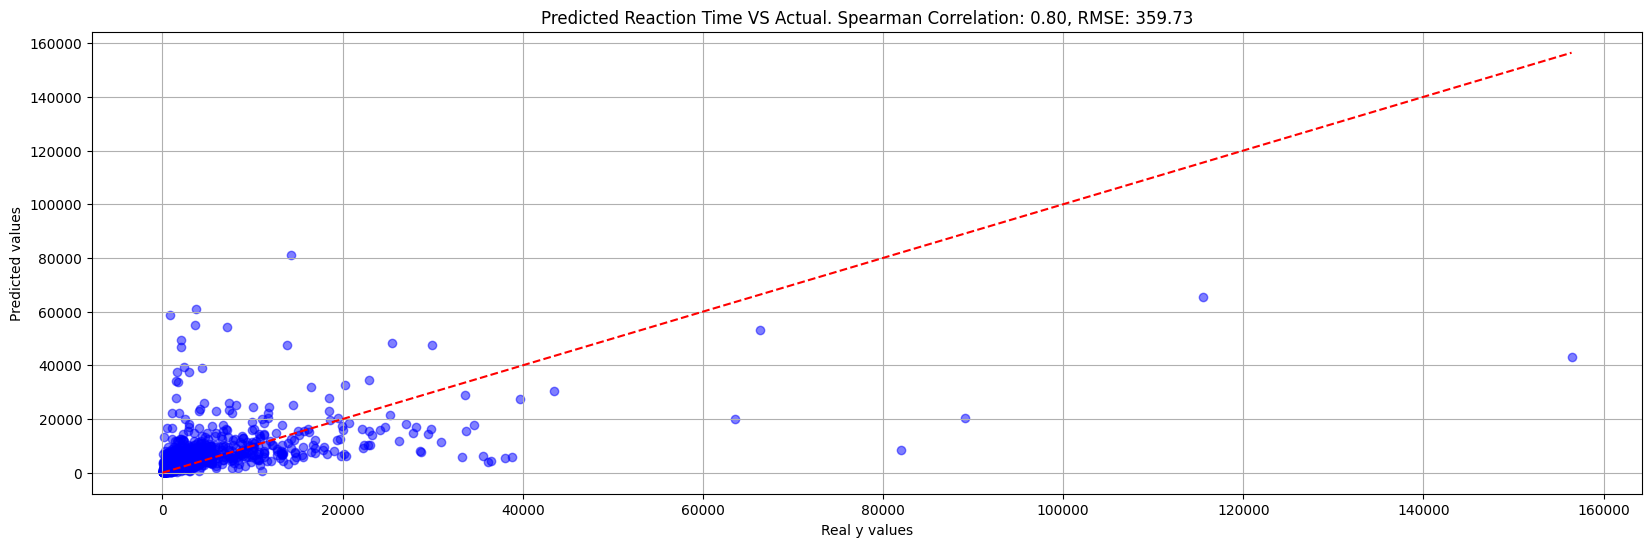

In [33]:
naive_model_rmse = np.sqrt(mean_squared_error(y_test, np.full(len(y_test), y_train.mean()), squared=False))
spearman = spearmanr(y_test, y_pred)[0]
plt.figure(figsize=(20, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=1000, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]

plt.scatter(sorted_y_test, sorted_y_pred, color='blue', alpha=0.5)

# Plot diagonal line
max_val = max(sorted_y_test.max(), sorted_y_pred.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')

# Set plot title with RMSE
plt.title(f"Predicted Reaction Time VS Actual. Spearman Correlation: {spearman:.2f}, RMSE: {rmse:.2f}")
plt.xlabel("Real y values")
plt.ylabel("Predicted values")
plt.grid(True)
plt.show()

In [34]:
naive_model_rmse

360.14691663580936

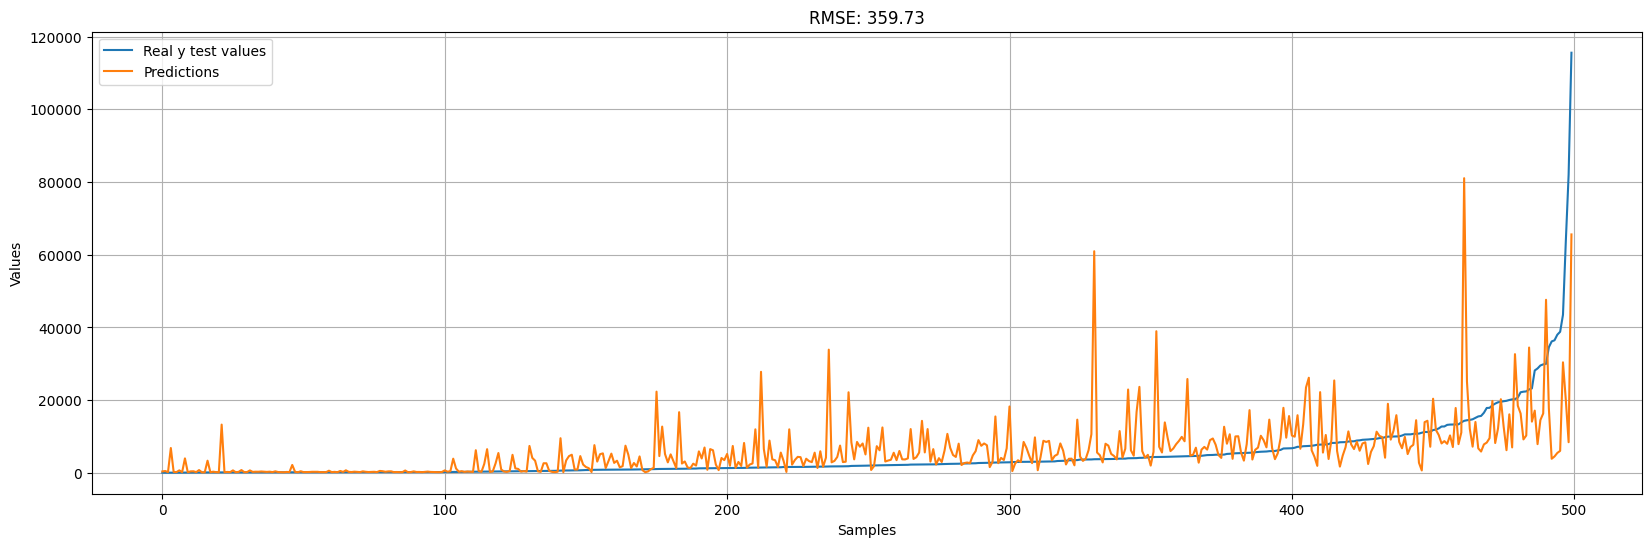

In [35]:
plt.figure(figsize=(20, 6))
np.random.seed(100)
random_indices = np.random.choice(len(y_test), size=500, replace=False)
sorted_indices = np.argsort(y_test.iloc[random_indices])
sorted_y_test = y_test.iloc[random_indices].iloc[sorted_indices]
sorted_y_pred = y_pred[random_indices][sorted_indices]
# Plot real y test values and predictions
plt.plot(sorted_y_test.reset_index(drop=True), label='Real y test values')
plt.plot(sorted_y_pred, label='Predictions')

# Set plot title with RMSE
plt.title(f"RMSE: {rmse:.2f}")
plt.xlabel("Samples")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
y_test_binned = pd.cut(y_test, bins=bin_edges, labels=labels, include_lowest=True)
y_pred_binned = pd.cut(y_pred, bins=bin_edges, labels=labels, include_lowest=True)

# Calculate accuracy
accuracy = accuracy_score(y_test_binned, y_pred_binned)
print("Accuracy:", accuracy)

# Calculate F1 score (use average='weighted' to handle class imbalance)
f1 = f1_score(y_test_binned, y_pred_binned, average='weighted')
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)
conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
print("Confusion Matrix:")
display(conf_matrix_df)

Accuracy: 0.361984
F1 Score: 0.365988969267236
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3176      532       210        123        128        115   
400-800        142      141        90         75        109        129   
800-1200        36       46        29         89        156        238   
1200-1600       18       29        20         52        157        284   
1600-2500       16       24        28         42        163        454   
2500-4000        0        8         8         21         83        382   
4000-6000        0        1         2          7         29        176   
6000-12000       0        1         1          8         14        111   
12000-20000      0        1         0          1          3         24   
20000+           0        0         1          3          1         18   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               98          72           16       8  
400-800            113          73            6       9  
800-1200           162         137           25      13  
1200-1600          267         244           34      25  
1600-2500          484         514           84      46  
2500-4000          532         592           93      52  
4000-6000          400         609          113      60  
6000-12000         353         954          285     119  
12000-20000         91         328          184      92  
20000+              48         197          163     175

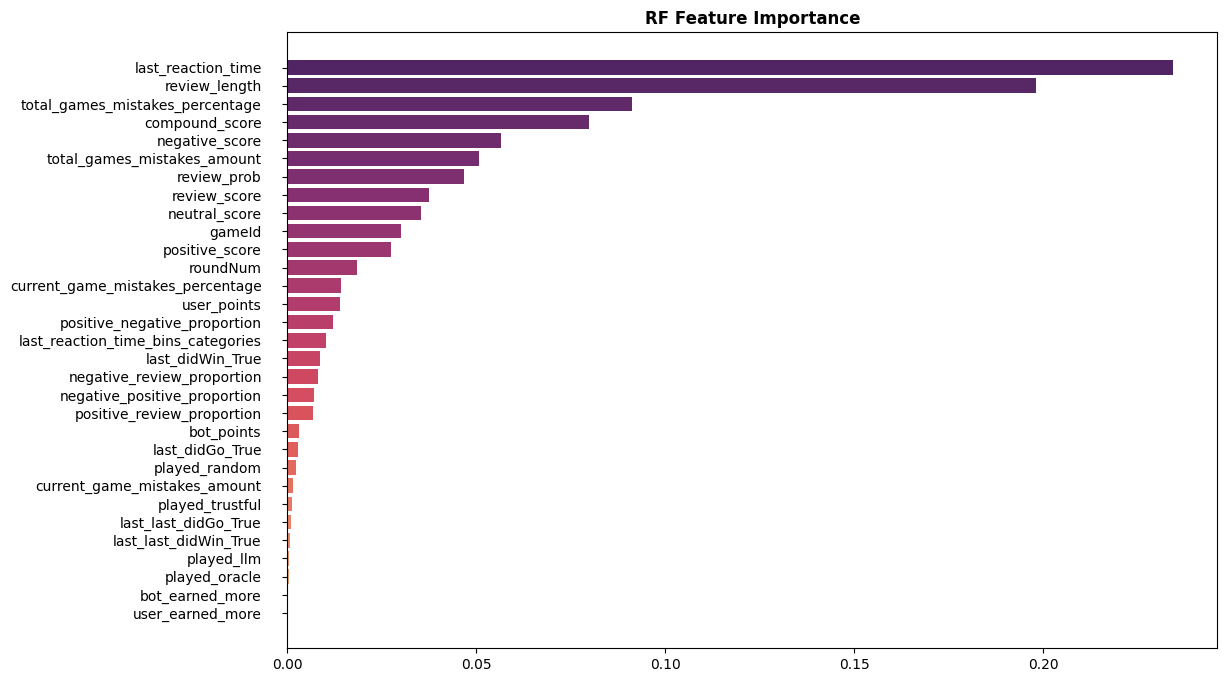

In [44]:
importances_df = pd.DataFrame({"feature_names" : model.feature_names_in_, "importances" : model.feature_importances_}).sort_values(by='importances', ascending=True)
colors = sns.color_palette("flare", len(model.feature_names_in_))

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_yticks(range(len(importances_df["feature_names"])))
ax.set_yticklabels(importances_df["feature_names"], fontsize=10)
ax.tick_params(axis='y', which='major', pad=15)
ax.set_title("RF Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()


In [52]:
selected_features = importances_df['feature_names'][-20:].tolist()

model = RandomForestRegressor(min_samples_leaf=50, max_depth=100)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])
rmse = np.sqrt(mean_squared_error(y_test, y_pred, squared=False))
print(rmse)

359.7418760721277


### Classification Modeling (Binning Representation)

In [53]:
all_features_classification = [feature for feature in all_features if feature != 'last_reaction_time']
X_train, y_train =  train_df[all_features_classification], train_df[classification_label_column]
X_test, y_test = test_df[all_features_classification], test_df[classification_label_column]

In [54]:
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[all_features_classification], y_train)
y_pred = classification_model.predict(X_test[all_features_classification])

In [56]:
train_mode = y_train.value_counts().idxmax()
naive_mode_predictions = np.full(len(y_test), train_mode)
accuracy = accuracy_score(y_test, naive_mode_predictions)
print("Naive Model:")
print("Accuracy:", accuracy)

f1 = f1_score(y_test, naive_mode_predictions, average='weighted')
print("F1 Score:", f1)

Naive Model:
Accuracy: 0.286592
F1 Score: 0.12767835407650602


In [57]:
def evaluate_classification_model(model):
    num_estimators = len(model.estimators_)
    print(f"Number of estimators: {num_estimators}")
    tree_depths = [estimator.tree_.max_depth for estimator in model.estimators_]
    print(f"Depth of each tree: {tree_depths}")
    average_depth = sum(tree_depths) / num_estimators
    print(f"Average depth of trees: {average_depth}")
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("F1 Score:", f1)
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=bin_labels[1:], columns=bin_labels[1:])
    print("Confusion Matrix:")
    display(conf_matrix_df)

In [58]:
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [18, 18, 18, 20, 18, 19, 18, 17, 22, 17, 20, 19, 21, 20, 18, 18, 19, 19, 18, 20, 18, 19, 20, 20, 19, 19, 17, 19, 19, 19, 20, 21, 18, 19, 20, 23, 19, 20, 17, 17, 19, 22, 18, 19, 20, 18, 18, 18, 21, 17, 19, 18, 18, 18, 22, 18, 19, 17, 19, 19, 18, 19, 19, 19, 19, 22, 21, 18, 18, 19, 21, 20, 19, 19, 20, 17, 18, 20, 19, 21, 19, 20, 17, 20, 18, 19, 20, 18, 18, 18, 20, 21, 20, 20, 17, 18, 18, 20, 19, 19]
Average depth of trees: 19.02
Accuracy: 0.406592
F1 Score: 0.41112229974130887
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3678      598       120         27         22         12   
400-800        176      457       156         44         13         11   
800-1200        45      229       335        146         61         37   
1200-1600       27      182       273        264        112         79   
1600-2500       23      273       313        327        235        184   
2500-4000        9      199       239        227        163        265   
4000-6000        4      142       118        105        109        177   
6000-12000       7      144        85         82         91        121   
12000-20000      2       65        24         29         24         23   
20000+           1       73        16         19         19         15   

             4000-6000  6000-12000  12000-20000  20000+  
0-400                8           6            3       4  
400-800             11           6            5       8  
800-1200            23          12           26      17  
1200-1600           51          51           51      40  
1600-2500          173         108          120      99  
2500-4000          268         162          130     109  
4000-6000          269         203          151     119  
6000-12000         312         395          350     259  
12000-20000         59         123          205     170  
20000+              39          50          124     250

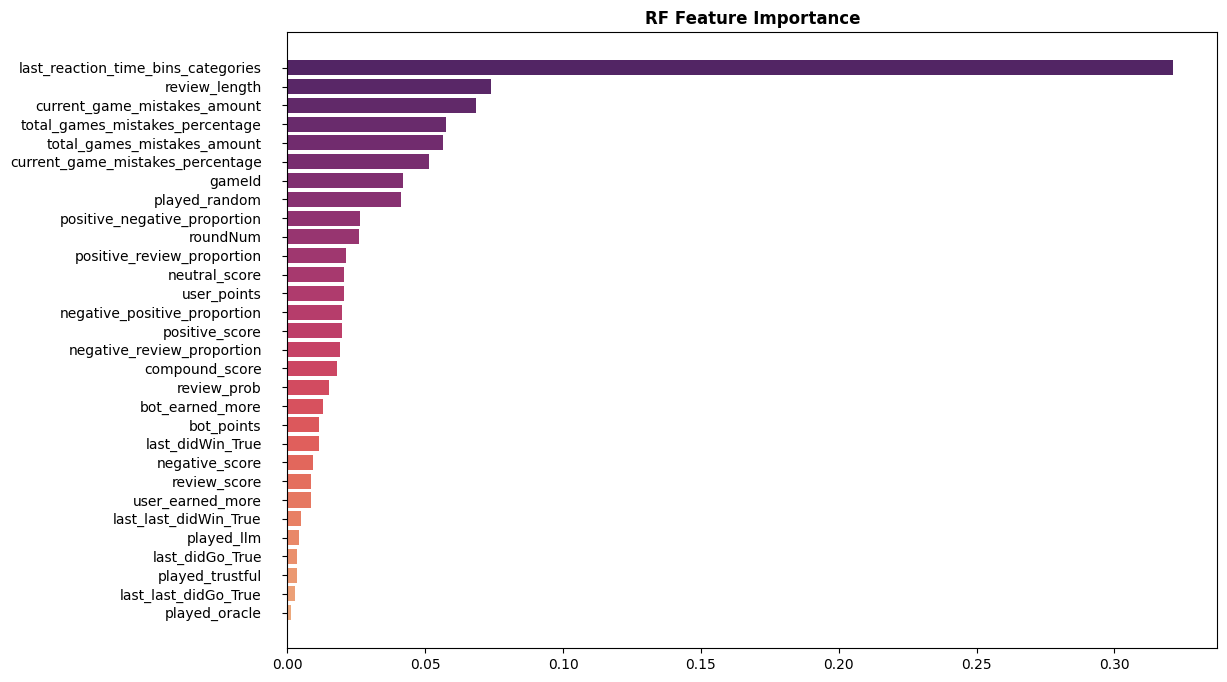

In [61]:
importances_df = pd.DataFrame({"feature_names" : classification_model.feature_names_in_, "importances" : classification_model.feature_importances_}).sort_values(by='importances', ascending=True)
colors = sns.color_palette("flare", len(classification_model.feature_names_in_))

fig, ax = plt.subplots(figsize=(12,8))
ax.barh(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_yticks(range(len(importances_df["feature_names"])))
ax.set_yticklabels(importances_df["feature_names"],  fontsize=10)
ax.tick_params(axis='y', which='major', pad=15)
ax.set_title("RF Feature Importance", fontweight = "bold")
plt.grid(False)
plt.show()

In [62]:
importances_df[-20:]['feature_names'].tolist()

['bot_points',
 'bot_earned_more',
 'review_prob',
 'compound_score',
 'negative_review_proportion',
 'positive_score',
 'negative_positive_proportion',
 'user_points',
 'neutral_score',
 'positive_review_proportion',
 'roundNum',
 'positive_negative_proportion',
 'played_random',
 'gameId',
 'current_game_mistakes_percentage',
 'total_games_mistakes_amount',
 'total_games_mistakes_percentage',
 'current_game_mistakes_amount',
 'review_length',
 'last_reaction_time_bins_categories']

In [63]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [19, 17, 19, 19, 18, 18, 19, 19, 17, 22, 21, 17, 21, 20, 18, 18, 18, 19, 20, 19, 20, 18, 18, 20, 19, 21, 18, 18, 20, 18, 17, 19, 17, 17, 18, 19, 17, 19, 18, 18, 18, 20, 17, 20, 21, 21, 19, 19, 18, 17, 19, 20, 19, 18, 17, 23, 18, 18, 18, 21, 19, 19, 20, 22, 21, 19, 20, 18, 19, 18, 22, 19, 17, 19, 22, 21, 20, 21, 21, 19, 19, 18, 20, 18, 20, 20, 17, 21, 19, 19, 18, 20, 19, 18, 20, 18, 20, 21, 19, 18]
Average depth of trees: 19.06
Accuracy: 0.407104
F1 Score: 0.4125193889555672
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3669      605       115         33         25          9   
400-800        173      443       149         63         17         14   
800-1200        43      234       323        143         61         34   
1200-1600       27      184       260        262        106         85   
1600-2500       21      266       288        319        246        194   
2500-4000        8      196       229        208        169        262   
4000-6000        3      126       110        102        110        164   
6000-12000       5      135        76         78         96        130   
12000-20000      2       56        19         28         26         22   
20000+           1       72        14         21         16         14   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               10           6            2       4  
400-800              9           6            5       8  
800-1200            30          14           31      18  
1200-1600           55          56           55      40  
1600-2500          187         114          122      98  
2500-4000          293         160          126     120  
4000-6000          289         218          160     115  
6000-12000         317         398          362     249  
12000-20000         65         117          223     166  
20000+              32          58          132     246

In [70]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=10, min_samples_leaf=20, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
Average depth of trees: 10.0
Accuracy: 0.402752
F1 Score: 0.40711889905612825
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3667      564       152         34         30         11   
400-800        173      438       172         47         20         11   
800-1200        44      222       352        128         75         26   
1200-1600       27      180       296        238        129         54   
1600-2500       21      271       329        320        234        163   
2500-4000        8      204       246        205        174        228   
4000-6000        3      135       122        100        101        154   
6000-12000       5      141        86         84         95        107   
12000-20000      2       58        26         32         24         13   
20000+           1       73        14         24         17          7   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               11           4            2       3  
400-800              9           6            5       6  
800-1200            27          12           23      22  
1200-1600           64          46           56      40  
1600-2500          179         109          113     116  
2500-4000          285         160          132     129  
4000-6000          292         209          153     128  
6000-12000         333         385          333     277  
12000-20000         67         118          201     183  
20000+              41          49          122     258

In [71]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=20, min_samples_leaf=20, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
Average depth of trees: 20.0
Accuracy: 0.40576
F1 Score: 0.41198149899159486
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3675      566       128         44         31         13   
400-800        175      441       153         50         20         19   
800-1200        44      216       328        139         76         39   
1200-1600       26      170       270        242        140         92   
1600-2500       22      259       297        296        277        200   
2500-4000        8      179       209        210        206        282   
4000-6000        3      122       106         88        124        195   
6000-12000       5      120        76         86         99        156   
12000-20000      2       51        19         29         29         29   
20000+           1       66        13         22         22         11   

             4000-6000  6000-12000  12000-20000  20000+  
0-400                8           7            2       4  
400-800              8           7            7       7  
800-1200            27          20           29      13  
1200-1600           54          49           52      35  
1600-2500          169         138          118      79  
2500-4000          260         208          115      94  
4000-6000          254         236          169     100  
6000-12000         305         425          349     225  
12000-20000         55         152          194     164  
20000+              38          64          147     222

In [72]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=20, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [18, 19, 18, 18, 20, 19, 17, 20, 18, 19, 20, 18, 19, 18, 20, 18, 19, 18, 17, 17, 20, 19, 18, 19, 19, 18, 20, 20, 19, 20, 17, 20, 17, 18, 20, 19, 20, 18, 18, 18, 18, 20, 18, 19, 18, 20, 19, 17, 20, 20, 17, 20, 18, 19, 20, 18, 19, 20, 18, 20, 18, 19, 18, 19, 18, 20, 19, 20, 18, 19, 20, 18, 18, 16, 20, 20, 20, 20, 19, 19, 20, 20, 19, 19, 20, 19, 19, 18, 19, 18, 19, 17, 18, 19, 18, 18, 19, 20, 20, 20]
Average depth of trees: 18.82
Accuracy: 0.404736
F1 Score: 0.409729283534492
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3672      600       110         42         27          7   
400-800        174      461       146         52         14         14   
800-1200        44      240       326        141         58         32   
1200-1600       27      198       278        228        119         76   
1600-2500       21      272       318        316        234        181   
2500-4000        8      200       228        219        167        259   
4000-6000        3      134       106        108        105        168   
6000-12000       5      132        79         90         91        126   
12000-20000      2       63        20         31         20         21   
20000+           1       73        14         22         20         12   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               12           3            2       3  
400-800             10           4            5       7  
800-1200            26          17           28      19  
1200-1600           56          52           57      39  
1600-2500          175         112          120     106  
2500-4000          293         156          128     113  
4000-6000          279         204          164     126  
6000-12000         301         406          363     253  
12000-20000         61         121          215     170  
20000+              34          63          123     244

In [73]:
chosen_features = importances_df[-20:]['feature_names'].tolist()
classification_model = RandomForestClassifier(max_depth=20, min_samples_leaf=100, class_weight="balanced_subsample")
classification_model.fit(X_train[chosen_features], y_train)
y_pred = classification_model.predict(X_test[chosen_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [15, 15, 15, 14, 18, 16, 16, 16, 15, 15, 17, 16, 17, 18, 16, 17, 16, 16, 16, 18, 17, 16, 16, 15, 14, 17, 17, 14, 17, 15, 16, 15, 17, 19, 15, 14, 15, 15, 15, 16, 17, 16, 16, 15, 16, 18, 15, 15, 16, 17, 17, 15, 17, 15, 16, 15, 16, 16, 15, 16, 15, 15, 18, 16, 16, 15, 15, 18, 16, 17, 16, 16, 16, 14, 17, 18, 16, 16, 17, 16, 15, 15, 16, 17, 16, 16, 15, 16, 17, 15, 16, 15, 14, 16, 14, 15, 16, 16, 16, 16]
Average depth of trees: 15.91
Accuracy: 0.40288
F1 Score: 0.406794588287623
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3656      605       126         38         23         11   
400-800        172      456       152         54         17          8   
800-1200        45      234       344        136         57         30   
1200-1600       27      188       288        249        108         65   
1600-2500       21      284       321        341        200        176   
2500-4000        9      210       242        226        138        257   
4000-6000        3      135       119        111         95        165   
6000-12000       5      142        86         93         77        113   
12000-20000      2       57        23         35         23         22   
20000+           1       72        16         21         16         12   

             4000-6000  6000-12000  12000-20000  20000+  
0-400               11           3            2       3  
400-800             10           4            5       9  
800-1200            20          15           27      23  
1200-1600           59          47           56      43  
1600-2500          177         105          112     118  
2500-4000          284         156          125     124  
4000-6000          287         195          152     135  
6000-12000         327         376          337     290  
12000-20000         56         115          206     185  
20000+              36          44          124     264

In [37]:
# import pickle
# with open('models/updated_large_model_wa_strategies_6.pkl', 'wb') as f:
#     pickle.dump(classification_model, f)

In [39]:
import pickle
with open('models/updated_large_model_with_strategies_7.pkl', 'wb') as f:
    pickle.dump(classification_model, f)

In [68]:
import pickle
with open('models/rf_basic_classification_model_1.pkl', 'rb') as f:
    trained_initial_model = pickle.load(f)

In [50]:
initial_features = trained_initial_model.feature_names_in_.tolist()
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[initial_features], y_train)
y_pred = classification_model.predict(X_test[initial_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [17, 19, 20, 17, 19, 18, 18, 18, 17, 23, 16, 18, 21, 18, 16, 17, 20, 17, 18, 18, 20, 18, 18, 19, 19, 20, 19, 18, 19, 18, 18, 17, 19, 21, 20, 17, 17, 16, 17, 19, 19, 19, 17, 17, 19, 20, 18, 16, 20, 19, 21, 18, 17, 19, 19, 18, 18, 20, 18, 17, 17, 20, 19, 17, 21, 17, 20, 18, 16, 17, 19, 18, 20, 18, 18, 19, 17, 18, 16, 18, 19, 20, 19, 19, 18, 19, 17, 17, 18, 18, 19, 17, 17, 17, 17, 16, 20, 19, 18, 20]
Average depth of trees: 18.3
Accuracy: 0.40192
F1 Score: 0.4063553392108302
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3667      597       127         29         24         19   
400-800        173      447       153         55         17         14   
800-1200        43      239       320        158         54         31   
1200-1600       27      180       292        243        131         60   
1600-2500       21      279       320        339        226        180   
2500-4000        8      196       248        208        173        245   
4000-6000        3      144       110        105         99        176   
6000-12000       5      144        84         74        116        121   
12000-20000      2       63        15         31         31         23   
20000+           1       73         7         21         13         15   

             4000-6000  6000-12000  12000-20000  20000+  
0-400                6           5            2       2  
400-800              8           6            4      10  
800-1200            25          16           25      20  
1200-1600           63          45           62      27  
1600-2500          157         109          121     103  
2500-4000          278         155          135     125  
4000-6000          270         199          163     128  
6000-12000         302         379          354     267  
12000-20000         58         115          215     171  
20000+              35          59          114     268

In [52]:
import pickle
with open('models/large_model_0_repeat.pkl', 'wb') as f:
    pickle.dump(classification_model, f)

In [55]:
initial_updated_features = initial_features + ['played_trustful', 'played_llm', 'played_random', 'played_oracle']
classification_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, class_weight="balanced_subsample")
classification_model.fit(X_train[initial_updated_features], y_train)
y_pred = classification_model.predict(X_test[initial_updated_features])
evaluate_classification_model(classification_model)

Number of estimators: 100
Depth of each tree: [17, 16, 18, 17, 18, 17, 19, 17, 20, 18, 23, 16, 19, 19, 18, 17, 20, 19, 16, 18, 21, 16, 17, 19, 20, 17, 19, 17, 23, 18, 19, 18, 17, 22, 19, 20, 19, 16, 19, 19, 16, 17, 18, 20, 18, 17, 17, 18, 18, 18, 18, 18, 18, 16, 18, 18, 19, 18, 17, 18, 18, 18, 19, 18, 18, 19, 17, 17, 21, 17, 18, 17, 19, 17, 17, 23, 17, 17, 20, 18, 20, 20, 22, 16, 20, 17, 20, 20, 16, 23, 17, 16, 16, 17, 17, 18, 18, 17, 17, 17]
Average depth of trees: 18.21
Accuracy: 0.403072
F1 Score: 0.40688608029084533
Confusion Matrix:


0-400  400-800  800-1200  1200-1600  1600-2500  2500-4000  \
0-400         3670      599       112         39         22         14   
400-800        173      450       146         62         17         12   
800-1200        44      235       321        158         55         31   
1200-1600       27      170       274        264        137         60   
1600-2500       21      274       308        351        226        192   
2500-4000        8      194       219        225        184        235   
4000-6000        3      142       113        103         97        177   
6000-12000       5      136        82         81        110        130   
12000-20000      2       59        21         27         32         25   
20000+           1       72        13         23         13         11   

             4000-6000  6000-12000  12000-20000  20000+  
0-400                9           6            3       4  
400-800             10           5            3       9  
800-1200            25          14           22      26  
1200-1600           52          54           53      39  
1600-2500          158         111          116      98  
2500-4000          290         166          126     124  
4000-6000          266         203          156     137  
6000-12000         304         385          351     262  
12000-20000         58         116          214     170  
20000+              35          56          115     267

In [56]:
import pickle
with open('models/large_model_0_repeat_with_strategies_9.pkl', 'wb') as f:
    pickle.dump(classification_model, f)

### Model Investigation

In [10]:
import pickle
with open('models/updated_large_model_with_strategies_7.pkl', 'rb') as f:
    trained_model = pickle.load(f)

In [29]:
explainer = shap.TreeExplainer(trained_model.estimators_[0])
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[100], feature_names=list(trained_model.feature_names_in_))

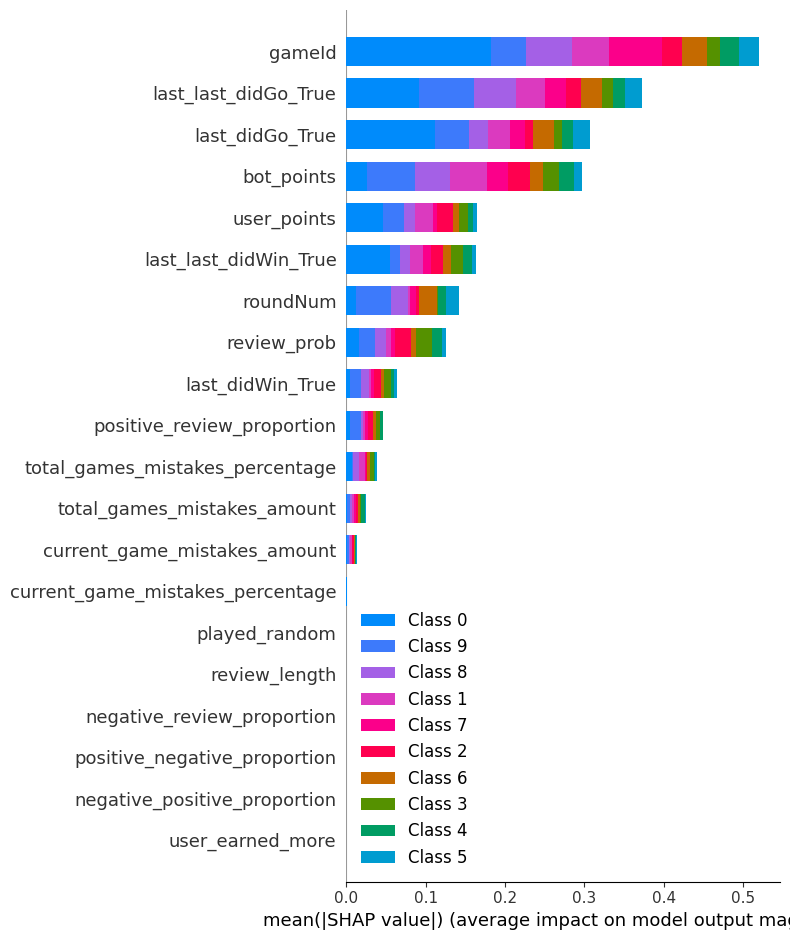

In [30]:
shap.summary_plot(shap_values, X_train)

In [35]:
for name in list(trained_model.feature_names_in_):
    shap.dependence_plot(name, shap_values, X_train)

TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

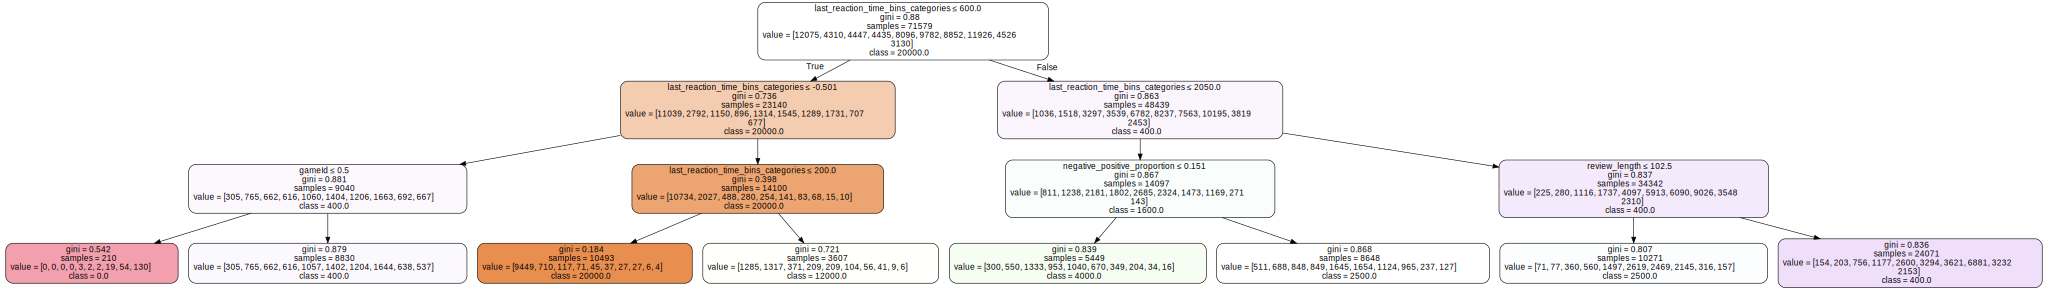

In [27]:
simple_model = DecisionTreeClassifier(max_depth=3)
simple_model.fit(X_train[list(trained_model.feature_names_in_)], y_train)
dot_data = export_graphviz(
    simple_model,
    out_file=None,
    feature_names=list(trained_model.feature_names_in_),
    class_names=[str(c) for c in y_train.unique()],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
graph

In [40]:
import lime
features = list(trained_model.feature_names_in_)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[features].values, 
    feature_names=features,
    class_names=y_train.unique().tolist(), 
    discretize_continuous=True
)

# Explain the first instance in the training set
exp = explainer_lime.explain_instance(X_train[features].iloc[100].values, trained_model.estimators_[0].predict_proba, num_features=4)
exp.show_in_notebook(show_table=True)

In [41]:
import lime
features = list(trained_model.feature_names_in_)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[features].values, 
    feature_names=features,
    class_names=y_train.unique().tolist(), 
    discretize_continuous=True
)

# Explain the first instance in the training set
exp = explainer_lime.explain_instance(X_train[features].iloc[100].values, trained_model.predict_proba, num_features=4)
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
